# WENO evolution

Having computed the WENO coefficients we want to check how the convergence rate goes.

In [1]:
import numpy
import weno_coefficients

In [2]:
def weno(order, q):
    """
    Do WENO reconstruction
    
    Parameters
    ----------
    
    order : int
        The stencil width
    q : numpy array
        Scalar data to reconstruct
        
    Returns
    -------
    
    qL : numpy array
        Reconstructed data - boundary points are zero
    """
    C = weno_coefficients.C_all[order]
    a = weno_coefficients.a_all[order]
    sigma = weno_coefficients.sigma_all[order]

    qL = numpy.zeros_like(q)
    beta = numpy.zeros((order, len(q)))
    w = numpy.zeros_like(beta)
    np = len(q) - 2 * order
    epsilon = 1e-16
    for i in range(order, np+order):
        q_stencils = numpy.zeros(order)
        alpha = numpy.zeros(order)
        for k in range(order):
            for l in range(order):
                for m in range(l+1):
                    beta[k, i] += sigma[k, l, m] * q[i+k-l] * q[i+k-m]
            alpha[k] = C[k] / (epsilon + beta[k, i]**2)
            for l in range(order):
                q_stencils[k] += a[k, l] * q[i+k-l]
        w[:, i] = alpha / numpy.sum(alpha)
        qL[i] = numpy.dot(w[:, i], q_stencils)
    
    return qL

In [16]:
def weno_advection_rhs(order, q, dx):
    """
    Compute the RHS for the 1d advection equation d_t q + d_x q = 0.
    """
    # For the advection case with v=1, the flux is given by the upwinded reconstruction
    flux = weno(order, q)
    rhs = numpy.zeros_like(q)
    rhs[order:-order] = (flux[order-1:-order-1] - flux[order:-order]) / dx
    return rhs

def periodic_bc(order, q):
    ng = order+1
    q[:ng] = q[-2*ng:-ng]
    q[-ng:] = q[ng:2*ng]
    return q

def rk3_step(order, q, dx, dt):
    q1 = periodic_bc(order, q + dt * weno_advection_rhs(order, q, dx))
    q2 = periodic_bc(order, (3 * q + q1 + dt * weno_advection_rhs(order, q1, dx)) / 4)
    return periodic_bc(order, (q + 2 * q2 + 2 * dt * weno_advection_rhs(order, q2, dx)) / 3)

def rk4_step(order, q, dx, dt):
    k1 = dt * weno_advection_rhs(order, q, dx)
    q1 = periodic_bc(order, q + k1 / 2)
    k2 = dt * weno_advection_rhs(order, q1, dx)
    q2 = periodic_bc(order, q + k2 / 2)
    k3 = dt * weno_advection_rhs(order, q2, dx)
    q3 = periodic_bc(order, q + k3)
    k4 = dt * weno_advection_rhs(order, q3, dx)
    q += (k1 + 2 * (k2 + k3) + k4) / 6
    return periodic_bc(order, q)

def evolve_one_period(order, q_init, cfl, Np):
    dx = 2 / Np
    dt = cfl * dx
    x = numpy.arange(dx * (1/2 - (order+1)), 2 + dx * (order+1), dx)
    q0 = (q_init(x+dx/2) - q_init(x-dx/2))/dx
    q = q0.copy()
    t = 0
    t_end = 2
    while t < t_end:
        if t + dt > t_end:
            dt = t_end - t
        t += dt
        q = rk4_step(order, q, dx, dt)
    residual = q - q0
    error_1 = numpy.linalg.norm(residual, 1) / Np
    error_2 = numpy.linalg.norm(residual, 2) / numpy.sqrt(Np)
    return error_1, error_2, q, x

def evolve_n_periods(order, q_init, cfl, Np, N):
    dx = 2 / Np
    dt = cfl * dx
    x = numpy.arange(dx * (1/2 - (order+1)), 2 + dx * (order+1), dx)
    q0 = (q_init(x+dx/2) - q_init(x-dx/2))/dx
    q = q0.copy()
    t = 0
    t_end = 2 * N
    while t < t_end:
        if t + dt > t_end:
            dt = t_end - t
        t += dt
        q = rk4_step(order, q, dx, dt)
    residual = q - q0
    error_1 = numpy.linalg.norm(residual, 1) / Np
    error_2 = numpy.linalg.norm(residual, 2) / numpy.sqrt(Np)
    return error_1, error_2, q, x

In [17]:
n_periods = 1
f_smooth = lambda x: numpy.sin(2 * n_periods * numpy.pi * x)
f_antiderivative = lambda x: -numpy.cos(2 * n_periods * numpy.pi * x) / (2 * n_periods * numpy.pi)

orders = numpy.arange(min(weno_coefficients.C_all.keys()), max(weno_coefficients.C_all.keys())+1)
points = 10 * 2**numpy.arange(1, 4)
error_1norm = numpy.zeros((len(points), len(orders)))
error_2norm = numpy.zeros((len(points), len(orders)))
for i, pts in enumerate(points):
    for j, order in enumerate(orders):
        error_1norm[i, j], error_2norm[i, j], q, x = evolve_one_period(order, f_antiderivative, 0.5, pts)
#        error_1norm[i, j], error_2norm[i, j], q, x = evolve_n_periods(order, f_antiderivative, 0.5, pts, 10)

In [18]:
%matplotlib inline
from matplotlib import pyplot

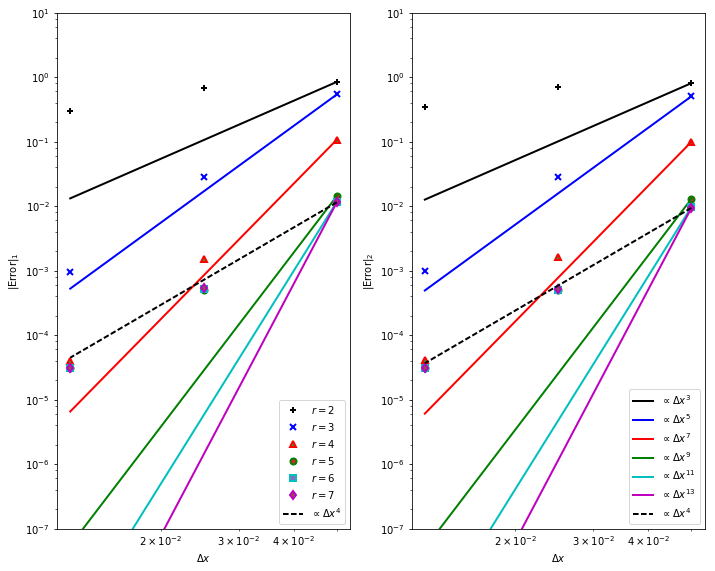

In [19]:
dxs = 1 / points
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 8))
markers = '+x^osd<'
colours = 'kbrgcm'
for i, order in enumerate(orders):
    axes[0].loglog(dxs, error_1norm[:, i], label=r"$r={}$".format(order),
                   linestyle=None, linewidth=0,
                   marker=markers[i], mec=colours[i], markersize=6, mew=2)
    axes[0].loglog(dxs, error_1norm[0, i] * (dxs/dxs[0])**(2*order-1),
                   linewidth=2, color=colours[i])
    axes[1].loglog(dxs, error_2norm[:, i], 
                   linestyle=None, linewidth=0,
                   marker=markers[i], mec=colours[i], markersize=6, mew=2)
    axes[1].loglog(dxs, error_2norm[0, i] * (dxs/dxs[0])**(2*order-1),
                   linewidth=2, color=colours[i],
                   label=r"$\propto \Delta x^{{{}}}$".format(2*order-1))

axes[0].loglog(dxs, error_1norm[0, -1]*(dxs/dxs[0])**4,
               linewidth=2, color='black', linestyle='--',
               label=r"$\propto \Delta x^4$")
axes[1].loglog(dxs, error_2norm[0, -1]*(dxs/dxs[0])**4,
               linewidth=2, color='black', linestyle='--',
               label=r"$\propto \Delta x^4$")
axes[0].set_xlabel(r"$\Delta x$")
axes[1].set_xlabel(r"$\Delta x$")
axes[0].set_ylabel(r"$|$Error$|_1$")
axes[1].set_ylabel(r"$|$Error$|_2$")
axes[0].set_ylim(1e-7, 1e1)
axes[1].set_ylim(1e-7, 1e1)
axes[0].legend()
axes[1].legend()
fig.tight_layout()

Convergence is not so clean, partly thanks to the time evolution scheme, and partly to the high accuracy of the method anyway. Essentially, once the error is below $\sim 10^{-6}$ it's dominated by the (fourth order) time evolution scheme.

In [22]:
n_periods = 1
f_smooth = lambda x: numpy.sin(2 * n_periods * numpy.pi * x)
f_antiderivative = lambda x: -numpy.cos(2 * n_periods * numpy.pi * x) / (2 * n_periods * numpy.pi)

orders = numpy.arange(min(weno_coefficients.C_all.keys()), max(weno_coefficients.C_all.keys())+1)
#orders = numpy.arange(min(weno_coefficients.C_all.keys()), 4)
points = 10 * 2**numpy.arange(1, 4)
error_1norm = numpy.zeros((len(points), len(orders)))
error_2norm = numpy.zeros((len(points), len(orders)))
for i, pts in enumerate(points):
    for j, order in enumerate(orders):
        cfl = 0.5 / 2**(len(points)-i)
        error_1norm[i, j], error_2norm[i, j], q, x = evolve_one_period(order, f_antiderivative, cfl, pts)

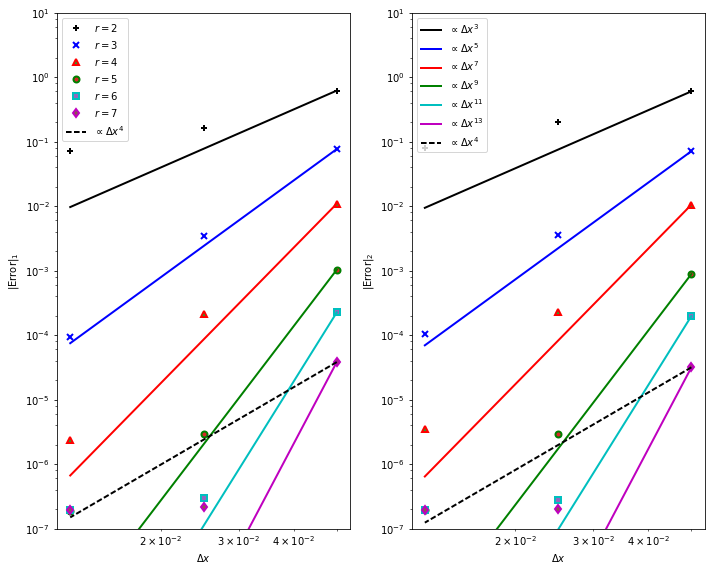

In [23]:
dxs = 1 / points
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 8))
markers = '+x^osd<'
colours = 'kbrgcm'
for i, order in enumerate(orders):
    axes[0].loglog(dxs, error_1norm[:, i], label=r"$r={}$".format(order),
                   linestyle=None, linewidth=0,
                   marker=markers[i], mec=colours[i], markersize=6, mew=2)
    axes[0].loglog(dxs, error_1norm[0, i] * (dxs/dxs[0])**(2*order-1),
                   linewidth=2, color=colours[i])
    axes[1].loglog(dxs, error_2norm[:, i], 
                   linestyle=None, linewidth=0,
                   marker=markers[i], mec=colours[i], markersize=6, mew=2)
    axes[1].loglog(dxs, error_2norm[0, i] * (dxs/dxs[0])**(2*order-1),
                   linewidth=2, color=colours[i],
                   label=r"$\propto \Delta x^{{{}}}$".format(2*order-1))

axes[0].loglog(dxs, error_1norm[0, -1]*(dxs/dxs[0])**4,
               linewidth=2, color='black', linestyle='--',
               label=r"$\propto \Delta x^4$")
axes[1].loglog(dxs, error_2norm[0, -1]*(dxs/dxs[0])**4,
               linewidth=2, color='black', linestyle='--',
               label=r"$\propto \Delta x^4$")
axes[0].set_xlabel(r"$\Delta x$")
axes[1].set_xlabel(r"$\Delta x$")
axes[0].set_ylabel(r"$|$Error$|_1$")
axes[1].set_ylabel(r"$|$Error$|_2$")
axes[0].set_ylim(1e-7, 1e1)
axes[1].set_ylim(1e-7, 1e1)
axes[0].legend()
axes[1].legend()
fig.tight_layout()